# 05 Comparative Visualization

This notebook generates scatter plots and other visualizations, comparing various dependency size metrics and linguistic factors. It uses the standardized plotting style (connecting lines to labels) for all scatter plots.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from importlib import reload

# Custom modules
import data_utils
import plotting

# Reload plotting to ensure latest style
reload(plotting)

%matplotlib inline

# Configuration
DATA_DIR = "data"
PLOTS_DIR = "plots"

## 1. Load Data

In [2]:
# Load metadata and metrics
metadata = data_utils.load_metadata(os.path.join(DATA_DIR, 'metadata.pkl'))
langNames = metadata['langNames']
langnameGroup = metadata['langnameGroup']
group_to_color = metadata['appearance_dict']

with open(os.path.join(DATA_DIR, 'all_langs_average_sizes_filtered.pkl'), 'rb') as f:
    all_langs_average_sizes_filtered = pickle.load(f)

# Load Pre-computed factors (e.g. HCS)
if os.path.exists(os.path.join(DATA_DIR, 'hcs_factors.csv')):
    hcs_df = pd.read_csv(os.path.join(DATA_DIR, 'hcs_factors.csv'))
else:
    print("Warning: hcs_factors.csv not found. Please run 04_data_processing using compute_factors.")
    hcs_df = pd.DataFrame()

if os.path.exists(os.path.join(DATA_DIR, 'vo_vs_hi_scores.csv')):
    vo_hi_df = pd.read_csv(os.path.join(DATA_DIR, 'vo_vs_hi_scores.csv'))
else:
    print("Warning: vo_vs_hi_scores.csv not found.")
    vo_hi_df = pd.DataFrame()

print(f"Loaded data for {len(all_langs_average_sizes_filtered)} languages")

Loaded metadata from data/metadata.pkl
Loaded data for 185 languages


In [3]:
# Load all_langs_average_charsizes
char_sizes_path = os.path.join(DATA_DIR, 'all_langs_average_charsizes.pkl')
if os.path.exists(char_sizes_path):
    with open(char_sizes_path, 'rb') as f:
        all_langs_average_charsizes = pickle.load(f)
    print(f"Loaded char sizes for {len(all_langs_average_charsizes)} languages")
else:
    print("Warning: all_langs_average_charsizes.pkl not found.")
    all_langs_average_charsizes = {}


Loaded char sizes for 185 languages


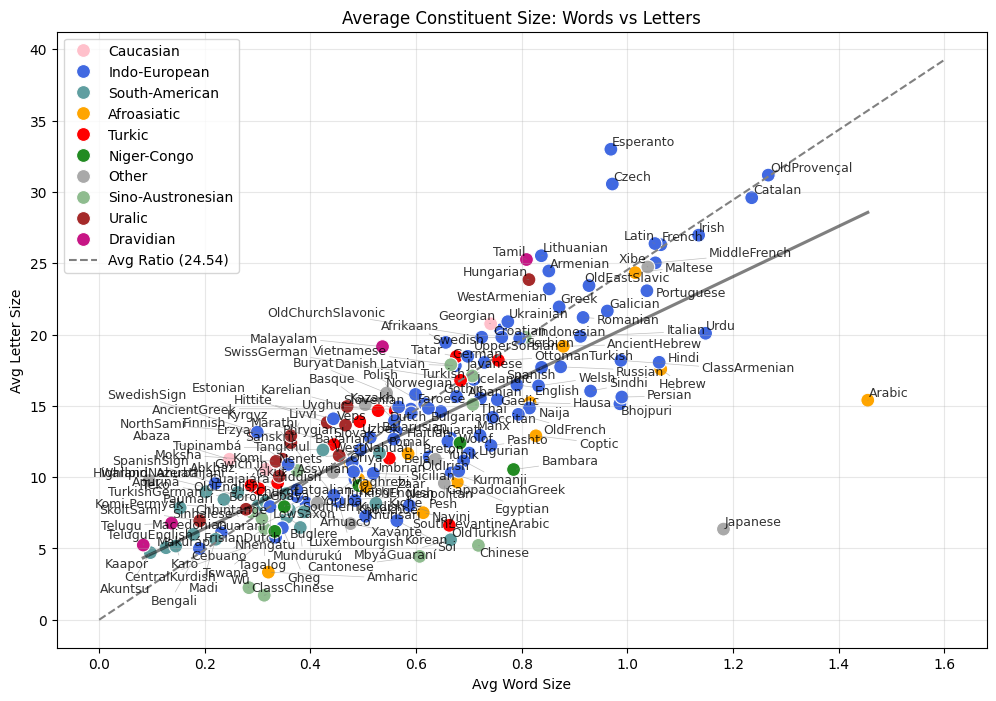

In [4]:
from scipy import stats
## Word vs Letter Size Analysis

# Compute averages per language
plot_data = []

for lang in all_langs_average_sizes_filtered:
    if lang in all_langs_average_charsizes:
        # Average across all tracked positions
        # We filter out positions with 0 count implicitly by using filtered dicts
        word_sizes = list(all_langs_average_sizes_filtered[lang].values())
        char_sizes = list(all_langs_average_charsizes[lang].values())
        
        if word_sizes and char_sizes:
            avg_word = sum(word_sizes) / len(word_sizes)
            avg_char = sum(char_sizes) / len(char_sizes)
            
            plot_data.append({
                'Language': langNames.get(lang, lang),
                'Group': langnameGroup.get(langNames.get(lang, lang), 'Other'),
                'Avg Word Size': avg_word,
                'Avg Letter Size': avg_char
            })

df_size = pd.DataFrame(plot_data)

if not df_size.empty:
    plt.figure(figsize=(12, 10))
    
    # 1. Scatter Plot
    sns.scatterplot(
        data=df_size, 
        x='Avg Word Size', 
        y='Avg Letter Size', 
        hue='Group', 
        palette=group_to_color,
        s=100
    )
    
    # 2. Add labels (using plotting util)
    plotting.adjust_text_labels(
        df_size, 
        'Avg Word Size', 
        'Avg Letter Size', 
        'Language', 
        ax=plt.gca()
    )
    
    # Calculate limits for diagonal lines
    max_x = df_size['Avg Word Size'].max()
    max_y = df_size['Avg Letter Size'].max()
    limit = max(max_x, max_y) * 1.1
    
    # 3. Linear Regression Trendline
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_size['Avg Word Size'], df_size['Avg Letter Size'])
    sns.regplot(
        data=df_size, 
        x='Avg Word Size', 
        y='Avg Letter Size', 
        scatter=False, 
        ci=None, 
        line_kws={'color': 'black', 'alpha': 0.8, 'linestyle': '-', 'linewidth': 2, 'label': f'Regression: y={slope:.2f}x+{intercept:.2f} ($R^2$={r_value**2:.2f})'}, 
        ax=plt.gca()
    )

    # 4. Average Ratio Line (Force through origin)
    avg_ratio = (df_size['Avg Letter Size'] / df_size['Avg Word Size']).mean()
    plt.plot([0, limit], [0, limit * avg_ratio], linestyle='--', color='blue', linewidth=2, alpha=0.7, label=f'Avg Ratio (y={avg_ratio:.2f}x)')

    # 5. Diagonal y=x
    plt.plot([0, limit], [0, limit], linestyle=':', color='gray', linewidth=2, alpha=0.7, label='Diagonal (y=x)')

    # Metadata & Formatting
    plt.title('Average Constituent Size: Words vs Letters')
    plt.xlabel('Average Constituent Size (Word Count)')
    plt.ylabel('Average Constituent Size (Letter Count)')
    plt.grid(True, alpha=0.3)
    
    # Set limits to ensure diagonals look correct relative to aspect ratio if square, 
    # but here we just ensure they cover the data.
    # We might want to start from 0 to see the origin clearly
    plt.xlim(0, limit)
    plt.ylim(0, limit)
    
    plt.legend(loc='upper left', framealpha=0.9)
    plt.tight_layout()
    plt.show()
    
    # Print detailed stats
    print(f"Regression: y = {slope:.4f}x + {intercept:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"Average Letter/Word Ratio: {avg_ratio:.4f}")
    
else:
    print("No data available for plotting.")

## 2. MAL Plots (Mean Average Length)

In [5]:
# Example MAL plot
# plotting.plot_dependency_sizes(
#     'right_1_totright_2', 'right_2_totright_2',
#     'MAL',
#     all_langs_average_sizes_filtered,
#     lambda x: True,
#     langNames, langnameGroup,
#     palette=group_to_color
# )

# producing loads of plots

this takes > 12 minutes

In [6]:
# Prepare Data for Filters (without generating plots)
import pandas as pd
import plotting
from importlib import reload
from tqdm.notebook import tqdm
# Reload plotting to get the latest sns.scatterplot changes and silent mode
reload(plotting)

print("Preparing language filters...")

# 1. Create mapping for Head Initiality & VO Score
# ---------------------------
if 'head_initiality_score' in vo_hi_df.columns:
    vo_hi_df['head_initiality'] = vo_hi_df['head_initiality_score']

join_col_hi = 'language' if 'language' in vo_hi_df.columns else 'language_code'
lang_to_head_init = vo_hi_df.set_index(join_col_hi)['head_initiality'].to_dict()

# Load vo_type classification (tripartite: VO/OV/NDO)
if 'vo_type' in vo_hi_df.columns:
    lang_to_vo_type = vo_hi_df.set_index(join_col_hi)['vo_type'].to_dict()
else:
    # Fallback: compute from vo_score if vo_type not available
    if 'vo_score' in vo_hi_df.columns:
        lang_to_vo = vo_hi_df.set_index(join_col_hi)['vo_score'].to_dict()
        lang_to_vo_type = {}
        for lang, score in lang_to_vo.items():
            if score is not None and not pd.isna(score):
                if score > 0.666:
                    lang_to_vo_type[lang] = 'VO'
                elif score < 0.333:
                    lang_to_vo_type[lang] = 'OV'
                else:
                    lang_to_vo_type[lang] = 'NDO'
            else:
                lang_to_vo_type[lang] = None
    else:
        lang_to_vo_type = {}
        print("Warning: Neither 'vo_type' nor 'vo_score' found in vo_hi_df. VO/OV/NDO plots will be skipped.")

# Calculate Lists of Languages for Parallel Processing
indo_euro_langs = {l for l in all_langs_average_sizes_filtered if langnameGroup.get(langNames.get(l, l), 'Other') == 'Indo-European'}
non_indo_euro_langs = {l for l in all_langs_average_sizes_filtered if langnameGroup.get(langNames.get(l, l), 'Other') != 'Indo-European'}

head_init_langs = {l for l in all_langs_average_sizes_filtered if lang_to_head_init.get(l, 0) > 0.5}
head_final_langs = {l for l in all_langs_average_sizes_filtered if lang_to_head_init.get(l, 0) <= 0.5}

# Tripartite word order classification
vo_langs = {l for l in all_langs_average_sizes_filtered if lang_to_vo_type.get(l) == 'VO'}
ov_langs = {l for l in all_langs_average_sizes_filtered if lang_to_vo_type.get(l) == 'OV'}
ndo_langs = {l for l in all_langs_average_sizes_filtered if lang_to_vo_type.get(l) == 'NDO'}

# Prepare factors dataframe
if not hcs_df.empty:
    merge_col = 'language' if 'language' in hcs_df.columns else 'language_code'
    if merge_col in hcs_df.columns:
        # Use the same join column logic
        join_col_hi = 'language' if 'language' in vo_hi_df.columns else 'language_code'
        head_init_df = vo_hi_df[[join_col_hi, 'head_initiality']].rename(columns={join_col_hi: merge_col})
        
        all_factors_df = pd.merge(hcs_df, head_init_df, on=merge_col, how='inner')
        all_factors_df['group'] = all_factors_df[merge_col].map(lambda x: langnameGroup.get(langNames.get(x, x), 'Other'))
        all_factors_df['language_name'] = all_factors_df[merge_col].map(lambda x: langNames.get(x, x))
    else:
        print("Warning: Merge col mismatch.")
        all_factors_df = pd.DataFrame()
else:
    print("Warning: hcs_factors.csv not available.")
    all_factors_df = pd.DataFrame()

print(f"\n✅ Filters prepared:")
print(f"  Indo-European: {len(indo_euro_langs)}")
print(f"  Non-Indo-European: {len(non_indo_euro_langs)}")
print(f"  Head-Initial: {len(head_init_langs)}")
print(f"  Head-Final: {len(head_final_langs)}")
print(f"  VO: {len(vo_langs)}")
print(f"  OV: {len(ov_langs)}")
print(f"  NDO: {len(ndo_langs)}")

Preparing language filters...

✅ Filters prepared:
  Indo-European: 91
  Non-Indo-European: 94
  Head-Initial: 66
  Head-Final: 119
  VO: 94
  OV: 68
  NDO: 23


In [ ]:
# Generate all plots (this cell takes > 12 minutes)
print("Starting generation of ALL plot subsets...")

# 1. Generate Head-Init vs Factors Plots
# --------------------------------------
print("\n--- Generating Head-Init vs Factors Plots ---")
if not all_factors_df.empty:
    plotting.plot_head_initiality_vs_factors(all_factors_df, group_to_color)
else:
    print("Skipping (no factors data)")

# 2. Generate Scatter Plot Subsets (Batch)
# ----------------------------------------
subsets = [
    ("Head Final Languages", "headFinal-", head_final_langs),
    ("Head Initial Languages", "headInit-", head_init_langs),
    ("Indo-European Languages", "IE-", indo_euro_langs),
    ("Non-Indo-European Languages", "noIE-", non_indo_euro_langs),
    ("VO (Verb-Object) Languages", "VO-", vo_langs),
    ("OV (Object-Verb) Languages", "OV-", ov_langs),
    ("NDO (No Dominant Order) Languages", "NDO-", ndo_langs)
]

print("\nGenerating scatter plots for subsets...")
# Use tqdm for the overall progress
pbar = tqdm(subsets, desc="Subsets")
for name, prefix, lang_set in pbar:
    pbar.set_postfix_str(f"Processing {name}")
    if not lang_set:
        # print(f"Skipping {name} (no languages found)")
        continue
        
    plotting.plot_all(
        all_langs_average_sizes_filtered, 
        langNames, 
        langnameGroup, 
        filter_lang=lang_set,
        langname_group_or_genus=langnameGroup, 
        folderprefix=prefix, 
        palette=group_to_color, 
        parallel=True
    )

print("\n✅ All plots generated!")

Starting generation of ALL plot subsets...

--- Generating Head-Init vs Factors Plots ---
Generating 9 scatter plots (3 versions per factor)...
Total tasks: 9
Using 80 CPU cores for parallel processing


Generating Head-Init Plots:   0%|          | 0/9 [00:00<?, ?it/s]


✅ Completed 6 scatter plots in plots/head_init_vs_factors/

Generating scatter plots for subsets...


Subsets:   0%|          | 0/7 [00:00<?, ?it/s]

_________________________ plotting all ___________________________ headFinal-
Total plots to generate: 60
Using 79 CPU cores for parallel processing


Generating plots:   0%|          | 0/60 [00:00<?, ?it/s]

\n✅ Completed 60 plots
_________________________ plotting all ___________________________ headInit-
Total plots to generate: 60
Using 79 CPU cores for parallel processing


Generating plots:   0%|          | 0/60 [00:00<?, ?it/s]

\n✅ Completed 60 plots
_________________________ plotting all ___________________________ IE-
Total plots to generate: 60
Using 79 CPU cores for parallel processing


Generating plots:   0%|          | 0/60 [00:00<?, ?it/s]

\n✅ Completed 60 plots
_________________________ plotting all ___________________________ noIE-
Total plots to generate: 60
Using 79 CPU cores for parallel processing


Generating plots:   0%|          | 0/60 [00:00<?, ?it/s]

## VSnom vs VOnom Analysis

Analyze the relationship between Nominal Subject-Verb order (VSnom score) and Nominal Verb-Object order (VOnom score) across different language groups.

**Note:**
- **VOnom**: Counts only **nominal (NOUN)** objects.
- **VSnom**: Counts only **nominal (NOUN)** subjects.
- The `sv_score` measures the proportion of nominal subjects that appear **after** the verb (VS order).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Debug: Check what columns we have
print("Available columns in vo_hi_df:")
print(vo_hi_df.columns.tolist())
print()

# Ensure join_col_hi is defined
if 'join_col_hi' not in dir():
    join_col_hi = 'language' if 'language' in vo_hi_df.columns else 'language_code'
    print(f"Setting join_col_hi to: {join_col_hi}")

# Create VS type mapping if not present
# Note: sv_score measures subjects AFTER verb (VS order), so high score = VS
if 'sv_type' in vo_hi_df.columns:
    lang_to_vs_type = vo_hi_df.set_index(join_col_hi)['sv_type'].to_dict()
else:
    # Fallback: compute from sv_score if sv_type not available
    if 'sv_score' in vo_hi_df.columns:
        lang_to_vs = vo_hi_df.set_index(join_col_hi)['sv_score'].to_dict()
        lang_to_vs_type = {}
        for lang, score in lang_to_vs.items():
            if score is not None and not pd.isna(score):
                if score > 0.666:
                    lang_to_vs_type[lang] = 'VS'  # Most subjects after verb
                elif score < 0.333:
                    lang_to_vs_type[lang] = 'SV'  # Most subjects before verb
                else:
                    lang_to_vs_type[lang] = 'NDO_SV'
            else:
                lang_to_vs_type[lang] = None
    else:
        lang_to_vs_type = {}
        print("⚠️ WARNING: Neither 'sv_type' nor 'sv_score' found in vo_hi_df.")
        print("Please ensure you have:")
        print("1. Re-run cell 9 in notebook 02 (conll_processing.get_all_stats_parallel)")
        print("2. Re-run cell 4 in this notebook (reload vo_vs_hi_scores.csv)")

# Calculate VS classification sets
sv_langs = {l for l in all_langs_average_sizes_filtered if lang_to_vs_type.get(l) == 'SV'}
vs_langs = {l for l in all_langs_average_sizes_filtered if lang_to_vs_type.get(l) == 'VS'}
ndo_sv_langs = {l for l in all_langs_average_sizes_filtered if lang_to_vs_type.get(l) == 'NDO_SV'}

print(f"SV languages (subjects before verb): {len(sv_langs)}")
print(f"VS languages (subjects after verb): {len(vs_langs)}")
print(f"NDO_SV languages: {len(ndo_sv_langs)}")

Available columns in vo_hi_df:
['vo_score', 'vo_type', 'vo_nominal_score', 'vo_nominal_type', 'sv_score', 'sv_type', 'head_initiality_score', 'vo_count', 'vo_nominal_count', 'sv_count', 'total_deps', 'vo_right', 'vo_nominal_right', 'sv_right', 'all_right', 'language_code', 'language_name', 'group', 'head_initiality']

SV languages (subjects before verb): 158
VS languages (subjects after verb): 10
NDO_SV languages: 16


### Generate VS vs VO Scatterplots for Different Language Groups

In [ ]:
# Generate VS vs VO scatterplots for different language groups (in parallel)
# Reload plotting to get the new function
reload(plotting)

# Define all language filters for batch processing
language_filters = [
    ("VS vs VO Scores - All Languages", "all_", set(all_langs_average_sizes_filtered.keys())),
    ("VS vs VO Scores - VO Languages (VO score > 66.6%)", "vo_", vo_langs),
    ("VS vs VO Scores - OV Languages (VO score < 33.3%)", "ov_", ov_langs),
    ("VS vs VO Scores - NDO Languages (33.3% ≤ VO score ≤ 66.6%)", "ndo_", ndo_langs),
    ("VS vs VO Scores - Indo-European Languages", "ie_", indo_euro_langs),
    ("VS vs VO Scores - Non-Indo-European Languages", "noie_", non_indo_euro_langs),
]

# Generate all plots in parallel
results = plotting.plot_sv_vs_vo_scatter_batch(
    vo_hi_df, 
    language_filters, 
    group_to_color, 
    plots_dir=PLOTS_DIR,
    parallel=True
)

Generating 6 VS vs VO scatterplots...
Using 79 CPU cores for parallel processing


Generating VS vs VO plots:   0%|          | 0/6 [00:00<?, ?it/s]


✅ Completed 6 VS vs VO plots

VS vs VO Analysis Statistics

VS vs VO Scores - All Languages:
  Total languages: 184
  Mean VS score: 0.180
  Mean VO score: 0.493
  Correlation: 0.436
  VO & VS (both >66.6%): 10
  VO & SV (VO>66.6%, VS<33.3%): 62
  OV & VS (VO<33.3%, VS>66.6%): 0
  OV & SV (both <33.3%): 65

VS vs VO Scores - VO Languages (VO score > 66.6%):
  Total languages: 78
  Mean VS score: 0.261
  Mean VO score: 0.858
  Correlation: 0.031
  VO & VS (both >66.6%): 10
  VO & SV (VO>66.6%, VS<33.3%): 62
  OV & VS (VO<33.3%, VS>66.6%): 0
  OV & SV (both <33.3%): 0

VS vs VO Scores - OV Languages (VO score < 33.3%):
  Total languages: 69
  Mean VS score: 0.066
  Mean VO score: 0.066
  Correlation: 0.360
  VO & VS (both >66.6%): 0
  VO & SV (VO>66.6%, VS<33.3%): 0
  OV & VS (VO<33.3%, VS>66.6%): 0
  OV & SV (both <33.3%): 65

VS vs VO Scores - NDO Languages (33.3% ≤ VO score ≤ 66.6%):
  Total languages: 37
  Mean VS score: 0.224
  Mean VO score: 0.517
  Correlation: 0.489
  VO & VS (b

## Bastard Dependency Analysis

This section analyzes the frequency of "bastard" dependencies (non-projective or displaced nodes) across languages.
Data is loaded from `bastard_stats.csv` (generated in Notebook 02).

In [ ]:
# Load and Merge Bastard Statistics
bastard_csv = os.path.join(DATA_DIR, 'bastard_stats.csv')

if os.path.exists(bastard_csv):
    bastard_df = pd.read_csv(bastard_csv)
    print(f"Loaded bastard stats for {len(bastard_df)} languages.")
    
    # Merge with VO/HI data for correlation analysis
    # bastard_df keys: Code, Language, Verbs, Bastards, Bastards_per_Verb_Pct
    # vo_hi_df keys: language_code, vo_score, head_initiality, group, ...
    
    if not vo_hi_df.empty:
        join_col = 'language_code' if 'language_code' in vo_hi_df.columns else 'language'
        
        # Ensure vo_hi_df has unique entries per language to avoid duplication
        vo_hi_unique = vo_hi_df.drop_duplicates(subset=[join_col])
        
        merged_bastard = pd.merge(
            bastard_df, 
            vo_hi_unique[[join_col, 'vo_score', 'head_initiality', 'group']], 
            left_on='Code', 
            right_on=join_col, 
            how='inner'
        )
        print(f"Merged with linguistic factors: {len(merged_bastard)} languages.")
        
        # Display top 5 most 'bastardly' languages
        print("\nTop 5 Languages by Bastard Percentage:")
        print(merged_bastard[['Language', 'Bastards_per_Verb_Pct', 'group']].head(5).to_string(index=False))
    else:
        print("Warning: vo_hi_df is empty. Correlations cannot be plotted.")
        merged_bastard = bastard_df
else:
    print("Warning: bastard_stats.csv not found. Please run Notebook 02 to generate it.")
    merged_bastard = pd.DataFrame()

Loaded bastard stats for 185 languages.
Merged with linguistic factors: 185 languages.

Top 5 Languages by Bastard Percentage:
    Language  Bastards_per_Verb_Pct         group
AncientGreek              30.090422 Indo-European
    Phrygian              24.786325 Indo-European
       Latin              19.802880 Indo-European
      Pashto              19.266055 Indo-European
OldProvençal              16.367959 Indo-European


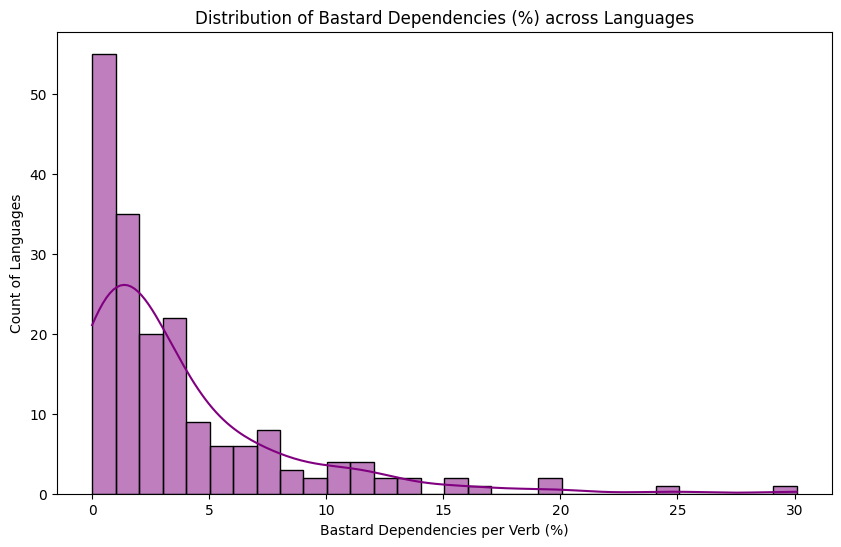

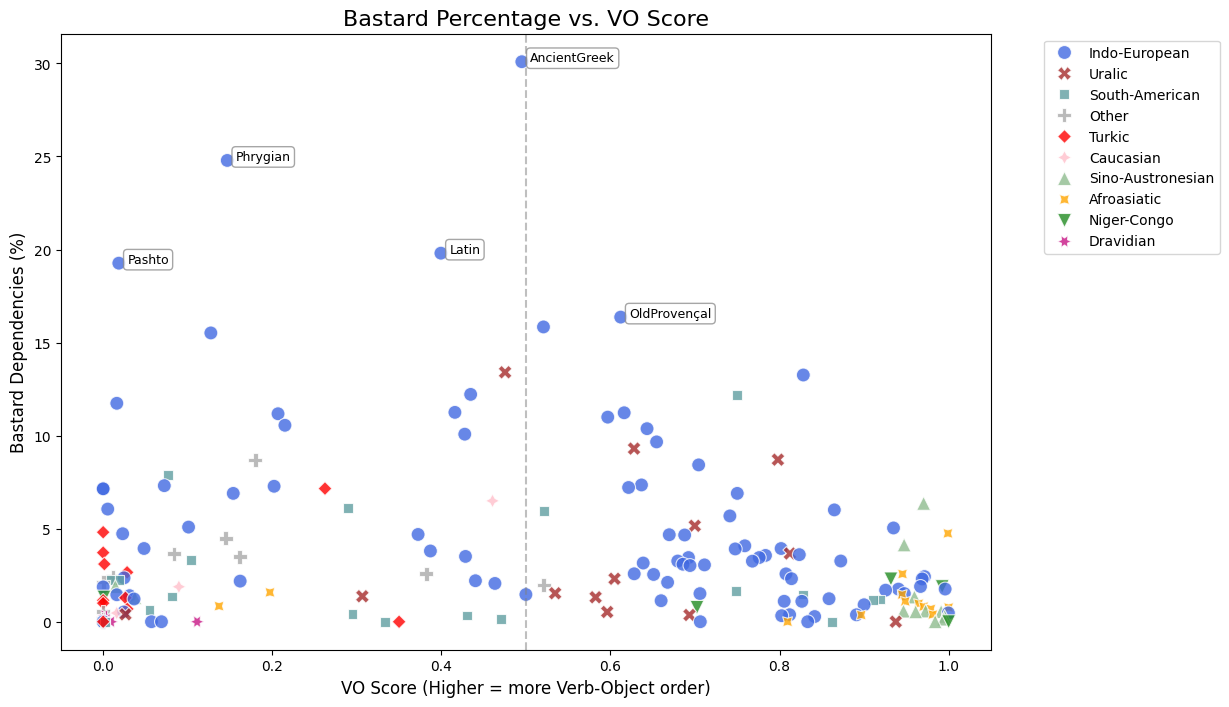

/tmp/ipykernel_1578191/2007468161.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='group', y='Bastards_per_Verb_Pct', palette=group_to_color)


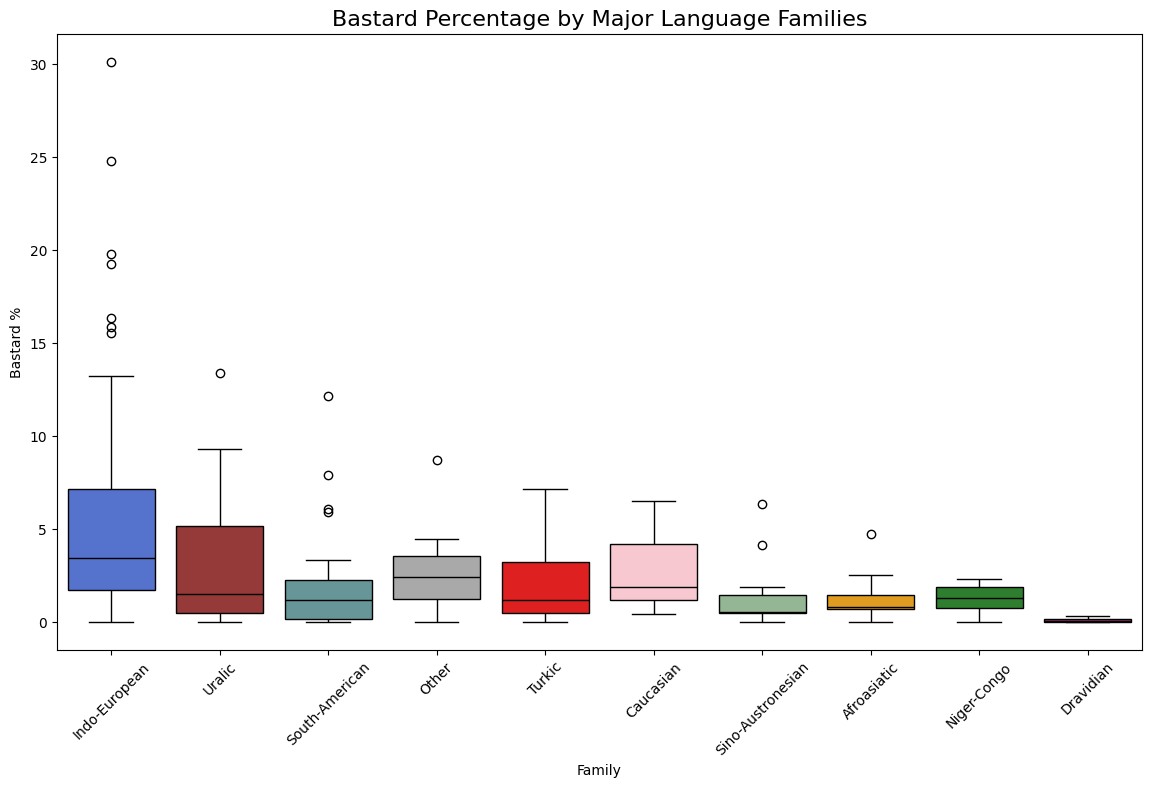

In [ ]:
# Visualizations
if not merged_bastard.empty:
    # 1. Histogram of Bastard Percentages
    plt.figure(figsize=(10, 6))
    sns.histplot(data=merged_bastard, x='Bastards_per_Verb_Pct', bins=30, kde=True, color='purple')
    plt.title('Distribution of Bastard Dependencies (%) across Languages')
    plt.xlabel('Bastard Dependencies per Verb (%)')
    plt.ylabel('Count of Languages')
    
    # Save plot
    if not os.path.exists(PLOTS_DIR):
        os.makedirs(PLOTS_DIR)
    plt.savefig(os.path.join(PLOTS_DIR, 'bastard_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Scatter Plot: Bastard % vs VO Score
    if 'vo_score' in merged_bastard.columns:
        plt.figure(figsize=(12, 8))
        ax = sns.scatterplot(
            data=merged_bastard, 
            x='vo_score', 
            y='Bastards_per_Verb_Pct', 
            hue='group', 
            palette=group_to_color,
            style='group',
            s=100,
            alpha=0.8
        )
        
        plt.title('Bastard Percentage vs. VO Score', fontsize=16)
        plt.xlabel('VO Score (Higher = more Verb-Object order)', fontsize=12)
        plt.ylabel('Bastard Dependencies (%)', fontsize=12)
        plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Label outliers or interesting points (Optional: Top 5)
        top_5 = merged_bastard.nlargest(5, 'Bastards_per_Verb_Pct')
        for _, row in top_5.iterrows():
            bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
            plt.text(
                row['vo_score']+0.01, 
                row['Bastards_per_Verb_Pct'], 
                row['Language'], 
                fontsize=9,
                bbox=bbox_props
            )

        plt.savefig(os.path.join(PLOTS_DIR, 'bastard_vs_vo_score.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Boxplot by Language Family (Top 10 families)
    if 'group' in merged_bastard.columns:
        top_families = merged_bastard['group'].value_counts().nlargest(10).index
        subset = merged_bastard[merged_bastard['group'].isin(top_families)]
        
        plt.figure(figsize=(14, 8))
        sns.boxplot(data=subset, x='group', y='Bastards_per_Verb_Pct', palette=group_to_color)
        plt.title('Bastard Percentage by Major Language Families', fontsize=16)
        plt.xlabel('Family')
        plt.ylabel('Bastard %')
        plt.xticks(rotation=45)
        
        plt.savefig(os.path.join(PLOTS_DIR, 'bastard_by_family.png'), dpi=300, bbox_inches='tight')
        plt.show()

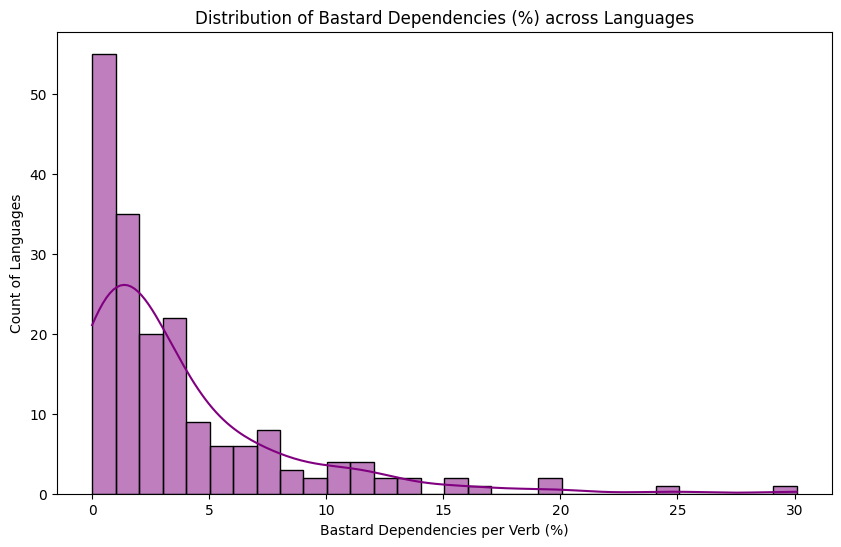

KeyboardInterrupt: 

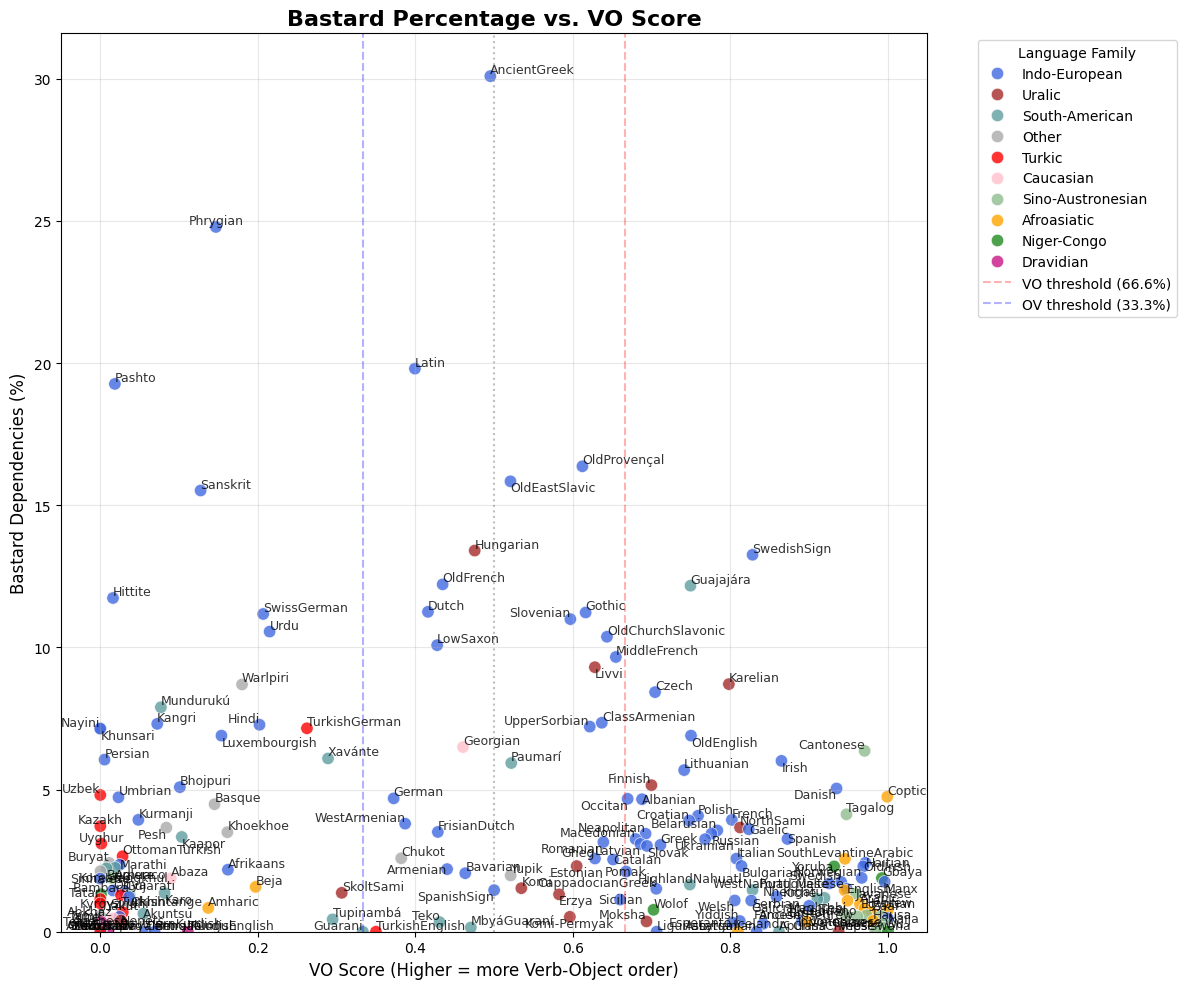

In [ ]:
# Visualizations using specialized function
if not merged_bastard.empty and 'vo_score' in merged_bastard.columns:
    # 1. Histogram of Bastard Percentages
    plt.figure(figsize=(10, 6))
    sns.histplot(data=merged_bastard, x='Bastards_per_Verb_Pct', bins=30, kde=True, color='purple')
    plt.title('Distribution of Bastard Dependencies (%) across Languages')
    plt.xlabel('Bastard Dependencies per Verb (%)')
    plt.ylabel('Count of Languages')
    if not os.path.exists(PLOTS_DIR):
        os.makedirs(PLOTS_DIR)
    plt.savefig(os.path.join(PLOTS_DIR, 'bastard_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Scatter Plot: Bastard % vs VO Score (Styled)
    if hasattr(plotting, 'plot_bastard_vs_vo_score'):
        reload(plotting)
        plotting.plot_bastard_vs_vo_score(
            merged_bastard, 
            group_to_color, 
            plots_dir=PLOTS_DIR, 
            title='Bastard Percentage vs. VO Score',
            filename='bastard_vs_vo_score.png'
        )
    else:
        print('Warning: plotting.plot_bastard_vs_vo_score not found. Please reload plotting module.')
    
    # 3. Boxplot by Language Family (Top 10 families)
    if 'group' in merged_bastard.columns:
        top_families = merged_bastard['group'].value_counts().nlargest(10).index
        subset = merged_bastard[merged_bastard['group'].isin(top_families)]
        
        plt.figure(figsize=(14, 8))
        sns.boxplot(data=subset, x='group', y='Bastards_per_Verb_Pct', palette=group_to_color)
        plt.title('Bastard Percentage by Major Language Families', fontsize=16)
        plt.xlabel('Family')
        plt.ylabel('Bastard %')
        plt.xticks(rotation=45)
        
        plt.savefig(os.path.join(PLOTS_DIR, 'bastard_by_family.png'), dpi=300, bbox_inches='tight')
        plt.show()

/bigstorage/kim/typometrics/dataanalysis/plotting.py:1472: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


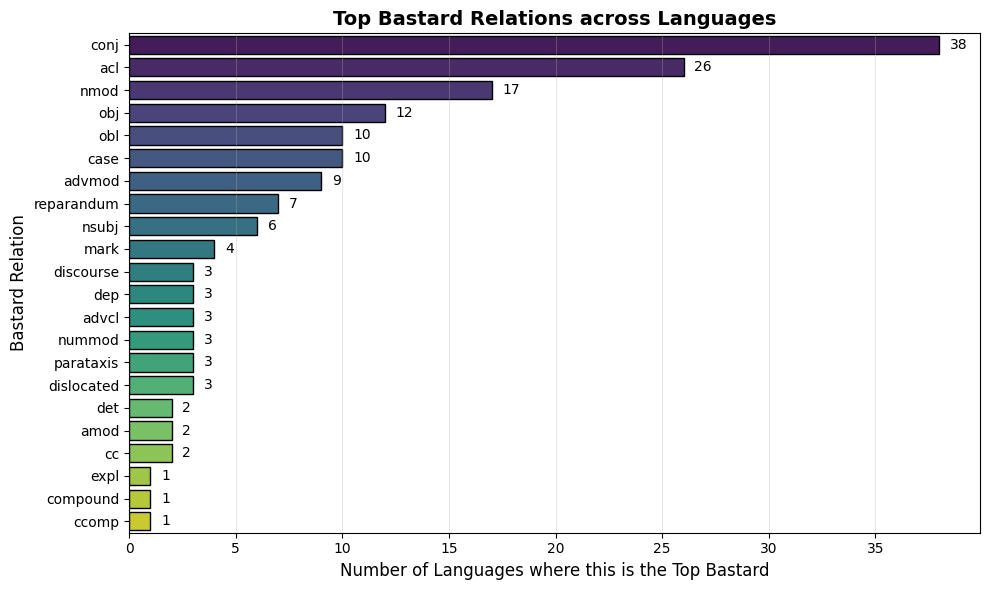

Saved plot to plots/bastard_analysis/top_bastard_distribution.png


In [ ]:

    # 4. Top Bastard Relations Distribution
    if hasattr(plotting, 'plot_top_bastard_distribution'):
        if 'Top_Bastard_Rel' in merged_bastard.columns:
            plotting.plot_top_bastard_distribution(
                merged_bastard, 
                plots_dir=PLOTS_DIR, 
                title='Top Bastard Relations across Languages',
                filename='top_bastard_distribution.png'
            )
        else:
            print('Top_Bastard_Rel column missing from data.')
    else:
        print('Warning: plotting.plot_top_bastard_distribution not found. Please reload plotting module.')


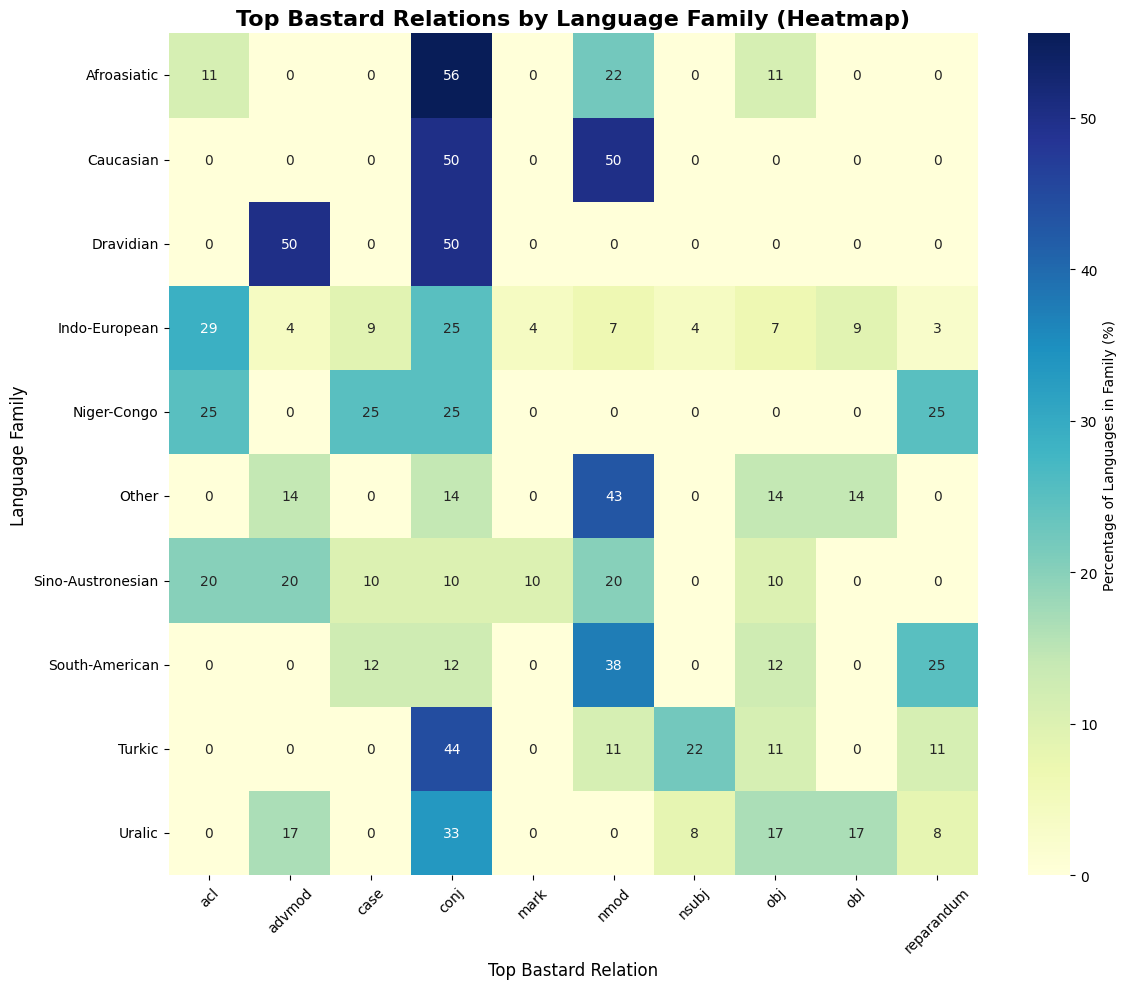

Saved plot to plots/bastard_analysis/bastard_relation_by_family.png


In [ ]:

    # 5. Top Bastard Relations by Family (Heatmap)
    if hasattr(plotting, 'plot_bastard_relation_by_family'):
        if 'Top_Bastard_Rel' in merged_bastard.columns and 'group' in merged_bastard.columns:
            plotting.plot_bastard_relation_by_family(
                merged_bastard, 
                plots_dir=PLOTS_DIR, 
                title='Top Bastard Relations by Language Family (Heatmap)',
                filename='bastard_relation_by_family.png'
            )
        else:
            print('Top_Bastard_Rel or group column missing from data.')
    else:
        print('Warning: plotting.plot_bastard_relation_by_family not found. Please reload plotting module.')


<Figure size 2400x1200 with 0 Axes>

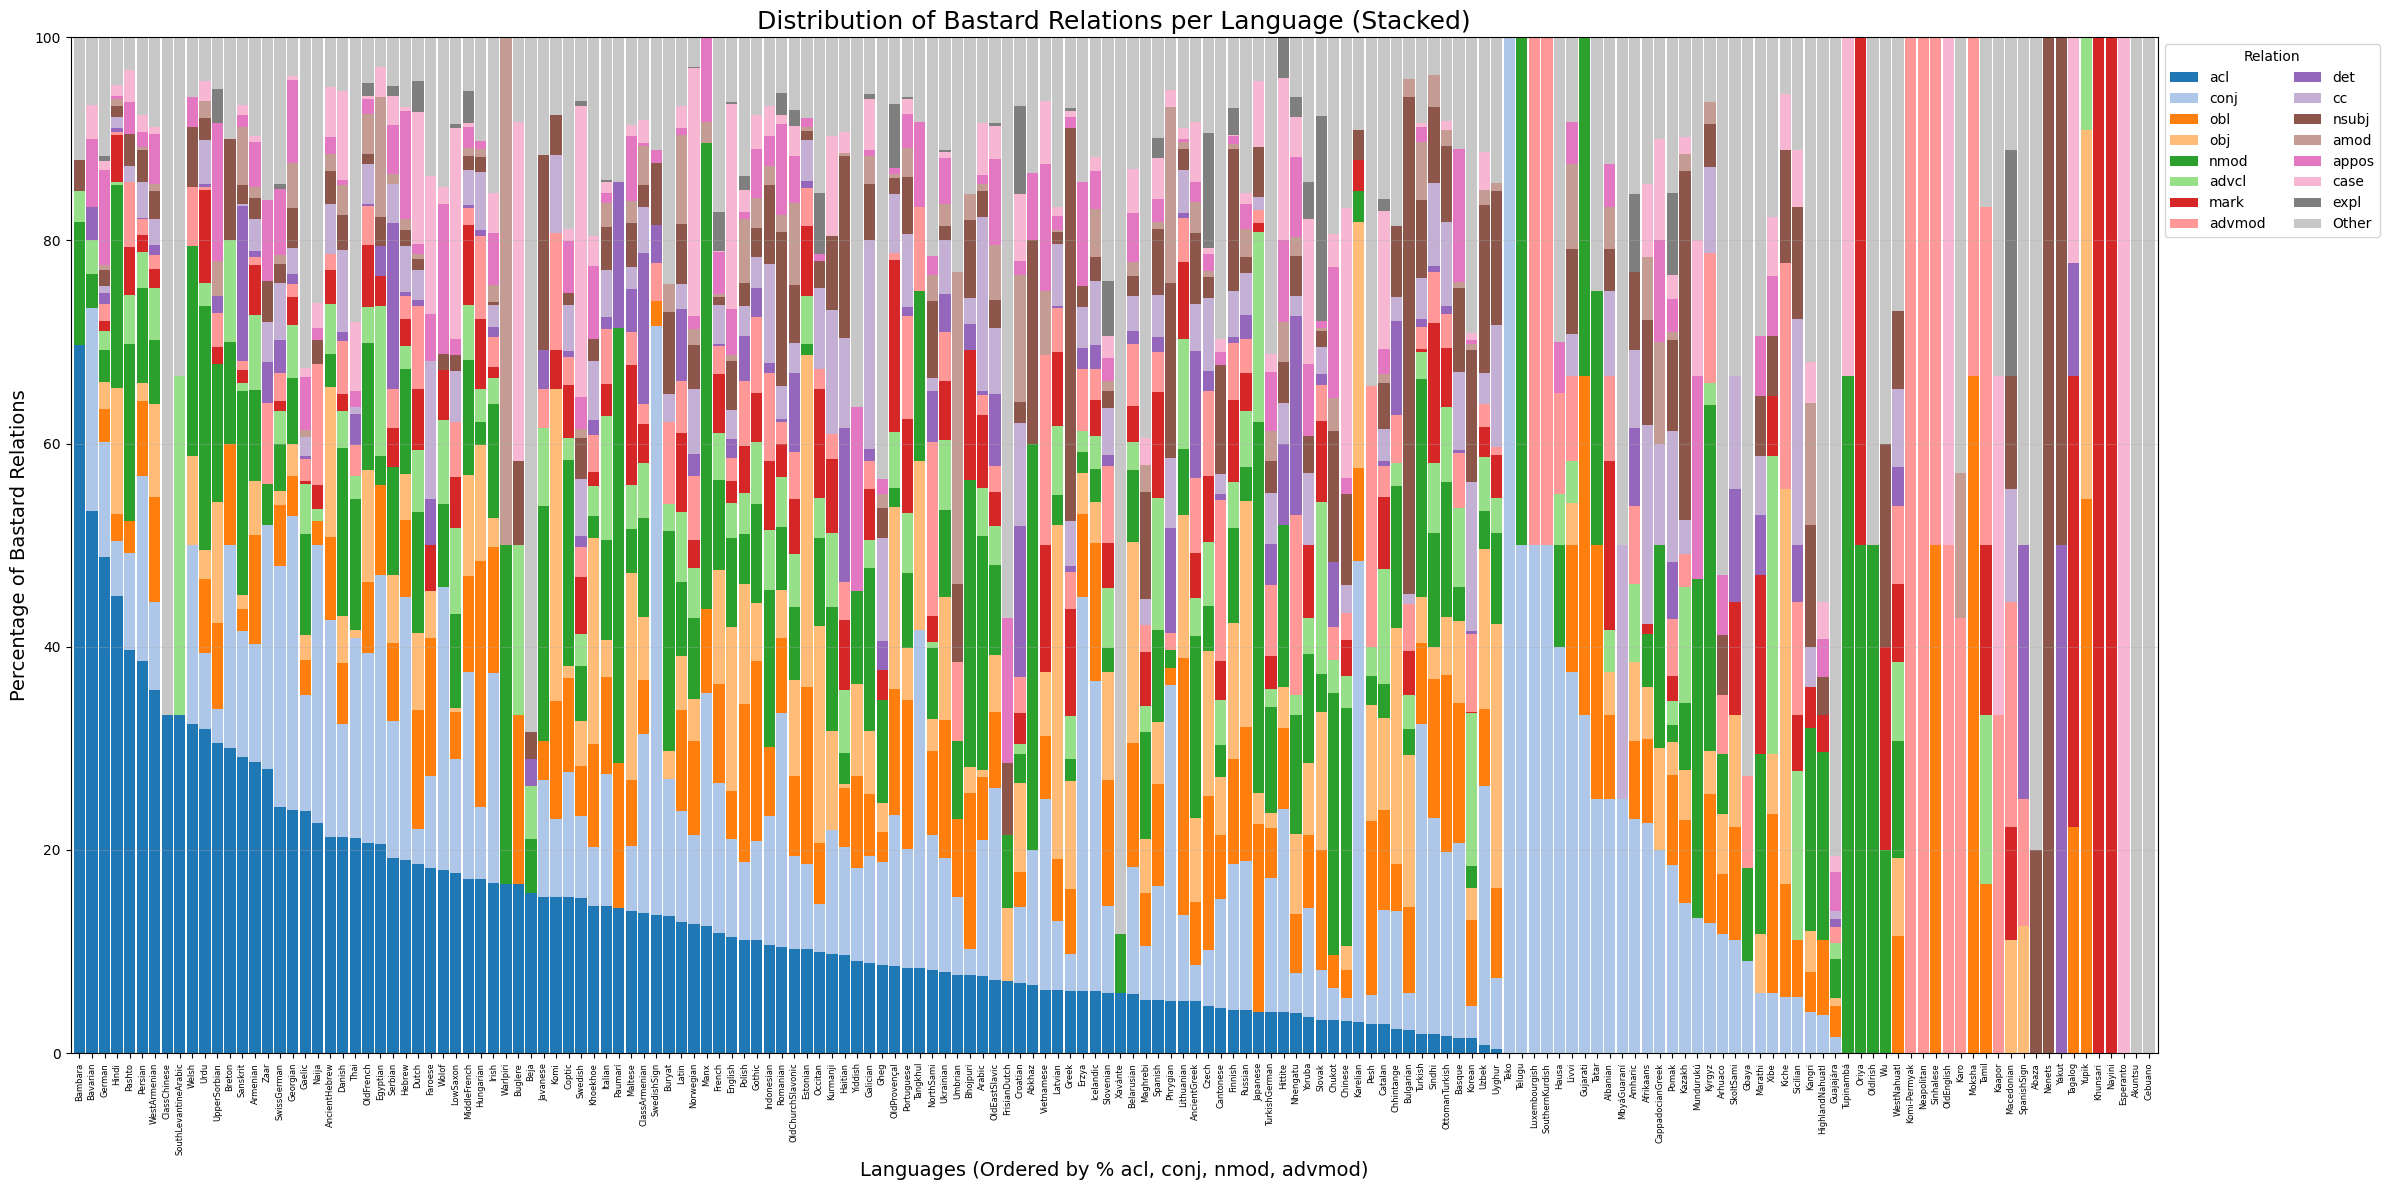

Saved stacked histogram to plots/bastard_analysis/bastard_relations_stacked.png


In [ ]:

    # 6. Additive Histogram of All Bastard Relations (Stacked)
    if hasattr(plotting, 'plot_additive_bastard_histogram'):
        relations_json = os.path.join(DATA_DIR, 'bastard_relations_per_lang.json')
        if os.path.exists(relations_json):
            plotting.plot_additive_bastard_histogram(
                relations_json, 
                lang_names=langNames, 
                plots_dir=PLOTS_DIR, 
                title='Distribution of Bastard Relations per Language (Stacked)',
                filename='bastard_relations_stacked.png'
            )
        else:
            print(f'Warning: {relations_json} not found. Please run Notebook 02 to generate it.')
    else:
        print('Warning: plotting.plot_additive_bastard_histogram not found. Please reload plotting module.')
